In [1]:
from molmap import dataset
from molmap import loadmap
import molmap

import matplotlib.pyplot as plt
from joblib import dump, load
from tqdm import tqdm
import pandas as pd
tqdm.pandas(ascii=True)

import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import MaxPool2D, GlobalMaxPool2D, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, Concatenate,Flatten, Dense, Dropout

%matplotlib inline
#use the second GPU, if negative value, CPUs will be used
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"



/home/shenwanxiang/anaconda3/envs/deepchem/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shenwanxiang/anaconda3/envs/deepchem/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shenwanxiang/anaconda3/envs/deepchem/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shenwanxiang/ana

In [2]:

def Inception(inputs, units = 8, strides = 1):
    """
    naive google inception block
    """
    x1 = Conv2D(units, 5, padding='same', activation = 'relu', strides = strides)(inputs)
    x2 = Conv2D(units, 3, padding='same', activation = 'relu', strides = strides)(inputs)
    x3 = Conv2D(units, 1, padding='same', activation = 'relu', strides = strides)(inputs)
    outputs = Concatenate()([x1, x2, x3])    
    return outputs


def SinglePathClassificationModel(molmap_shape,  n_outputs = 1, strides = 1):
    """molmap_shape: w, h, c"""
    
    assert len(molmap_shape) == 3
    inputs = Input(molmap_shape)
    
    conv1 = Conv2D(48, 13, padding = 'same', activation='relu', strides = 1)(inputs)
    
    conv1 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(conv1) #p1
    
    incept1 = Inception(conv1, strides = 1, units = 32)
    
    incept1 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(incept1) #p2
    
    incept2 = Inception(incept1, strides = 1, units = 64)
    
    #flatten
    flat1 = GlobalMaxPool2D()(incept2)   
    d1 = Dense(128,activation='relu')(flat1)
    d1 = Dense(64,activation='relu')(d1)
    outputs = Dense(n_outputs,activation='linear')(d1)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

def DoublePathClassificationModel(molmap1_size, molmap2_size, n_outputs = 1):
    
    ## first inputs
    d_inputs1 = Input(molmap1_size)
    d_conv1 = Conv2D(48, 13, padding = 'same', activation='relu', strides = 1)(d_inputs1)
    d_pool1 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(d_conv1) #p1
    d_incept1 = Inception(d_pool1, strides = 1, units = 32)
    d_pool2 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(d_incept1) #p2
    d_incept2 = Inception(d_pool2, strides = 1, units = 64)
    d_flat1 = GlobalMaxPool2D()(d_incept2)

    
    ## second inputs
    f_inputs1 = Input(molmap2_size)
    f_conv1 = Conv2D(48, 13, padding = 'same', activation='relu', strides = 1)(f_inputs1)
    f_pool1 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(f_conv1) #p1
    f_incept1 = Inception(f_pool1, strides = 1, units = 32)
    f_pool2 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(f_incept1) #p2
    f_incept2 = Inception(f_pool2, strides = 1, units = 64)
    f_flat1 = GlobalMaxPool2D()(f_incept2)    
    
    ## concat
    merge = Concatenate()([d_flat1, f_flat1]) 
    d1 = Dense(128,activation='relu')(merge)
    d1 = Dense(64,activation='relu')(d1)
    outputs = Dense(n_outputs, activation='linear')(d1)
    
    model = tf.keras.Model(inputs=[d_inputs1, f_inputs1], outputs=outputs)
    
    return model

In [3]:
seed = 777
np.random.seed(seed)
tf.set_random_seed(seed)

#load dataset
data = dataset.load_malaria()
df = data.data

# calculate feature
X1_name =  './descriptor_grid_split.data'
X2_name =  './fingerprint_grid_split.data'

if os.path.exists(X1_name):
    X1 = load(X1_name)
else:
    mp1 = loadmap('../../../descriptor_grid_split.mp')
    X1 = mp1.batch_transform(data.x, n_jobs = 8)
    dump(X1, X1_name)
    
if os.path.exists(X2_name):
    X2 = load(X2_name)
else:
    mp2 = loadmap('../../../fingerprint_grid_split.mp')
    X2 = mp2.batch_transform(data.x, n_jobs = 8)
    dump(X2, X2_name)

total samples: 9999


In [4]:
Y = data.y

df_train = pd.read_csv('../train.csv', index_col = 0)
df_valid = pd.read_csv('../valid.csv', index_col = 0)
df_test = pd.read_csv('../test.csv', index_col = 0)

train_idx = df[df.smiles.isin(df_train.smiles)].index
valid_idx = df[df.smiles.isin(df_valid.smiles)].index
test_idx = df[df.smiles.isin(df_test.smiles)].index


trainY = Y[train_idx]
validY = Y[valid_idx]
testY = Y[test_idx]


# trainX = X1[train_idx]   
# validX =  X1[valid_idx]                  
# testX  = X1[test_idx]

trainX = (X1[train_idx], X2[train_idx])    
validX = (X1[valid_idx], X2[valid_idx])                    
testX  = (X1[test_idx], X2[test_idx]) 


print(len(train_idx), len(valid_idx), len(test_idx))

7999 1000 1000


In [5]:
from cbks import RegressionPerformance, EarlyStoppingAtMinLoss
molmap1_size = X1.shape[1:]
molmap2_size = X2.shape[1:]
model = DoublePathClassificationModel(molmap1_size, molmap2_size, n_outputs = Y.shape[1]) 
#model = SinglePathClassificationModel(molmap1_size, n_outputs = Y.shape[1]) 

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
earlystop = EarlyStoppingAtMinLoss(patience=30, criteria = 'val_loss')
performace = RegressionPerformance((trainX, trainY), (validX, validY))
lr = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
model.compile(optimizer = lr, loss = 'mse')

In [7]:
model.fit(trainX, trainY, batch_size=128, 
      epochs=500, verbose= 0, shuffle = True, 
      validation_data = (validX, validY), 
      callbacks=[performace, earlystop]) 

epoch: 0001, loss: 1.4745 - val_loss: 1.2864; rmse: 1.2017 - rmse_val: 1.1342;  r2: 0.0220 - r2_val: 0.0295                                                                                                    
epoch: 0002, loss: 1.3969 - val_loss: 1.2129; rmse: 1.1562 - rmse_val: 1.1013;  r2: 0.0946 - r2_val: 0.0850                                                                                                    
epoch: 0003, loss: 1.2977 - val_loss: 1.1418; rmse: 1.1114 - rmse_val: 1.0686;  r2: 0.1634 - r2_val: 0.1386                                                                                                    
epoch: 0004, loss: 1.2000 - val_loss: 1.1620; rmse: 1.0862 - rmse_val: 1.0780;  r2: 0.2010 - r2_val: 0.1234                                                                                                    
epoch: 0005, loss: 1.1535 - val_loss: 1.0536; rmse: 1.0458 - rmse_val: 1.0264;  r2: 0.2593 - r2_val: 0.2052                                                             

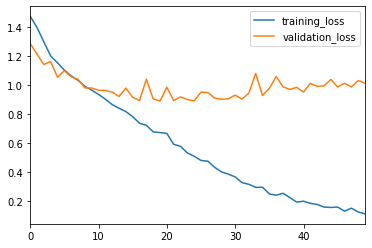

In [8]:
dfp = pd.DataFrame(performace.history)[['training_loss', 'validation_loss']]
dfp.plot()

In [9]:
performace.evaluate(trainX, trainY)

([0.7715097232808611], [0.5968848281779668])

In [10]:
performace.evaluate(validX, validY)

([0.9432285952065095], [0.3288151144226562])

In [11]:
performace.evaluate(testX, testY)

([1.014179462768426], [0.36711992227785084])